# Example: Solution of Discretized Linear Ordinary Differential Equation
This example will familiarize students with the discretization of a scalar linear ordinary differential equation and its solution as a set of Linear Algebraic Equations (LAEs). 

### Problem
Set up a system of linear algebraic equations whose solution describes concentration as a function of time for a compound $A$ that undergoes first-order decay in a constant volume, isothermal well-mixed batch reactor (no flow in or out). The concentration balance for compound $A$ is given by:

$$
\frac{dC_{A}}{dt} = -\kappa\cdot{C_{A}}
$$

where $\kappa$ denotes the first-order rate constant governing the rate of decay (units: 1/time), where the initial condition is given by $C_{A,0}$. Discretize the concentration balance using a [forward finite difference](https://en.wikipedia.org/wiki/Finite_difference) approximation of the time derivative:

$$
C_{A,j+1} = C_{A,j} - h\cdot\kappa\cdot{C_{A,j}}\qquad{j=0,2,n}
$$

where $h$ denotes the time step-size, $C_{A,\star}$ denotes the concentration of $A$ at time-step $\star$ and $n$ denotes the _number_ of time steps. Starting with $j=0$, construct a $n\times{n}$ matrix where each row is a time-step and each column is a concentration value:

$$
\begin{pmatrix}
1 & 0 & \dots & 0 \\
(\kappa\cdot{h} - 1) & 1 & \dots & 0 \\
\vdots & \vdots & \vdots & \vdots \\
0 & \dots & (\kappa\cdot{h} - 1) & 1
\end{pmatrix}
\begin{pmatrix}
C_{A,1} \\
C_{A,2} \\
\vdots \\
C_{A,n}
\end{pmatrix} = 
\begin{pmatrix}
C_{A,0}\left(1-h\cdot\kappa\right) \\
0 \\
\vdots \\
0 
\end{pmatrix}
$$

Thus, the problem of estimating the concentration of compound $A$ as a function of time reduces to the solution of a system of linear algebraic equations of the form:

$$
\mathbf{A}\mathbf{x} = \mathbf{b}
$$

## Setup
This example requires several external libraries and a function to compute the outer product. Let's download and install these packages and call our `Include.jl` file.

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9a`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9a/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9a/Manifest.toml`


## Prerequisites
Before we do any computation, let's specify some constant values, namely, the step size $h$ (which controls how fine the time resolution is), the first-order rate $\kappa$, the initial concentration of compound $A$, etc.
* Let $C_{A,0} = 10~\text{mmol/L}$, $\kappa = 1.0~\text{hr}^{-1}$, $h = 0.1~\text{hr}$ and the final time $T_{f} = 20.0~\text{hr}$.

In [2]:
κ = 1.0;  # rate constant units 1/hr 
CAₒ = 10.0; # initial concentration value units mmol/L
h = 0.01; # step size
TF = 20.0; # final time units hr
n = (TF/h |> Int) + 1; # number of time steps (must be an Int, not a Float), +1 because we start at 0

In this case, we know the analytical solution, so we can compare the values of $C_{A}(t)$ estimated by the finite difference approach to the analytical solution. Let's compute the analytical solution and store it in the `analytical_solution_array` variable:

In [3]:
analytical_solution_array = Array{Float64,2}(undef, n, 2);
T = range(0,TF,step=h) |> collect;
for i ∈ eachindex(T)
    analytical_solution_array[i,1] = T[i];
    analytical_solution_array[i,2] = CAₒ*exp(-κ*T[i]);
end

### Check: Let's check the stability of the differencing scheme
Since we have a scalar system, the condition for stability of the forward difference approximation is given by:
$$
\text{abs}\left(1 - h\cdot\kappa\right) < 1
$$
Let's check this condition using the Julia [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). If this condition is not less than `1`, then a [Assertion error](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) will be thrown.

In [4]:
@assert abs((1-h*κ)) < 1

## Setup the system matrix $\mathbf{A}$ and the right-hand side vector $\mathbf{b}$
Let's start by constructing the system matrix $\mathbf{A}\in\mathbb{R}^{n\times{n}}$, and then we'll construct the right-hand size vector $\mathbf{b}$. The system matrix $\mathbf{A}$ will have `three` cases that we need to worry about:
* If the `row = col`, then we put a `1`, i.e., there are `1's` along the diagonal of $\mathbf{A}$.
* If the `row = col+1` then we put the $(\kappa\cdot{h}-1)$ terms
* For everything else, we put values of `0`.

In [5]:
A = Array{Float64,2}(undef,n,n); # initialize an n x n matrix
for i = 1:n
    for j = 1:n
        if (i == j)
            A[i,j] = 1.0;
        elseif (j == i-1)
            A[i,j] = (κ*h - 1)
        else
            A[i,j] = 0.0
        end
    end
end
A

2001×2001 Matrix{Float64}:
  1.0    0.0    0.0    0.0    0.0    0.0   …   0.0    0.0    0.0    0.0   0.0
 -0.99   1.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0   0.0
  0.0   -0.99   1.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0   0.0
  0.0    0.0   -0.99   1.0    0.0    0.0       0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0   -0.99   1.0    0.0       0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0   -0.99   1.0   …   0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0    0.0   -0.99      0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0    0.0    0.0   …   0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0    0.0    

#### Check: Is the system matrix $\mathbf{A}$ diagonally dominant and full rank?
The `rank` check is easy; we call the [rank function built-in to Julia](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.rank). For the general case of a $\mathbf{A}\in\mathbb{R}^{m\times{n}}$ matrix the rank is given by $\text{rank}\left(\mathbf{A}\right)\leq\min\left(m,n\right)$. 
* In this case, we have a square $n\times{n}$ matrix $\mathbf{A}$, so that the full rank condition says `rank(A) = n`. We'll check this condition using the Julia [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). If we `fail` this check, i.e., `rank(A) < n`, then an [Assertion error](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown.

In [6]:
@assert rank(A) == n

Next, let's check for the diagonal dominance. Diagonal dominance is a sufficient (but not necessary) condition for convergence (a measure of the distance between the current best solution and the actual solution) of an iterative method.
$$
\begin{equation}
\sum_{j=1,i}^{n}\lvert{a_{ij}}\rvert<\lvert{a_{ii}}\rvert\qquad\forall{i}
\end{equation}
$$

* Diagonal dominance is a matrix property where the absolute value of the diagonal element of each row is greater than or equal to the sum of the absolute values of the other elements in that row.
A matrix that satisfies this property is said to be diagonally dominant.
* Diagonal dominance is a sufficient (but not necessary) condition for convergence. 
However, this condition says nothing above the rate of convergence.

In [7]:
ddcondition = Dict{Int64,Bool}()
for i ∈ 1:n
    aii = abs(A[i,i]);
    σ = 0.0;
    for j ∈ 1:n
        if (i ≠ j)
            σ += abs(A[i,j]);
        end
    end
    ddcondition[i] = (aii > σ) ? true : false;
end

In [8]:
(findall(x-> x == false, ddcondition) |> isempty)

true

### Setup the right-hand side vector $\mathbf{b}$
For this problem, the right-hand side vector $\mathbf{b}\in\mathbf{R}^{n}$ will have only one non-zero entry, namely, the first entry at time $t = 0$. 
* At time $t = 0$, the right-hand side of the discretized balance equation is given by $C_{A,0}\left(1-h\cdot\kappa\right)$
* However, for every other time step $\mathbf{b}$ has values of `0`, i.e., $b_{i}=0,i=1,\dots,n$.

In [9]:
b = zeros(n);
b[1] = CAₒ*(1-κ*h);

## Solve the system of LAEs for the unknown concentration values
We can use several methods to estimate the unknown concentration values by solving the Linear Algebraic Equations (LAEs) system. We have diagonal dominance so that the iterative techniques will work. In addition, Gaussian elimination and [QR decomposition](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.qr) should also work.
* Let's start by setting up an initial guess for the solution in the `xₒ` variable.  and then set some other parameters that our various solvers require

In [10]:
xₒ = rand(n); # initial condition
maxiterations = 250;
ϵ = 1e-6;

Now, call the `solve(...)` function with your LAE system matrix, the right-hand side vector, and which solver you want to use. We implemented the solvers in the [src/Solvers.jl](src/Solvers.jl) file. 
* Iterative solvers return a dictionary holding every iteration, where the last iteration will be the best. On the other hand, Gaussian Elimination or QR decomposition returns the final solution vector.

In [11]:
solution = solve(A,b,xₒ, ϵ = ϵ, maxiterations = maxiterations, algorithm = MyGaussSeidelMethod())

# uncomment me if NOT iterative method
# d = Dict{Int64, Vector{Float64}}();
# d[0] = solution;

# uncomment me IF iterative method
d = solution;

In [12]:
length(d)

2

Get the best solution (always the last element in the solution dictionary):

In [13]:
idx_last_iteration = keys(d) |> collect |> sort |> last; # Fancy - what???
tmp = d[idx_last_iteration];

Finally, we can put everything in the `estimated_solution_array` variable, where each row is a time point. Column `1` holds the time value, and column `2` has the estimated concentration value:

In [14]:
estimated_solution_array = Array{Float64,2}(undef, n, 2);
for i ∈ eachindex(T)

    estimated_solution_array[i,1] = T[i];
    if (i == 1)
        estimated_solution_array[i,2] = CAₒ;
    else
        estimated_solution_array[i,2] = tmp[i];
    end
end

#### Check: How good is the estimated solution?
Let's compute the [vector norm](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.norm) of the difference between the estimated solution and the analytical solution (the closer these solutions, the smaller the value of the [vector norm](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.norm)):

In [15]:
δ = norm(estimated_solution_array[:,2] - analytical_solution_array[:,2])

0.8973077815241584

`Unhide` the code block below to see how we plotted the estimated and analytical solutions of the decay problem:

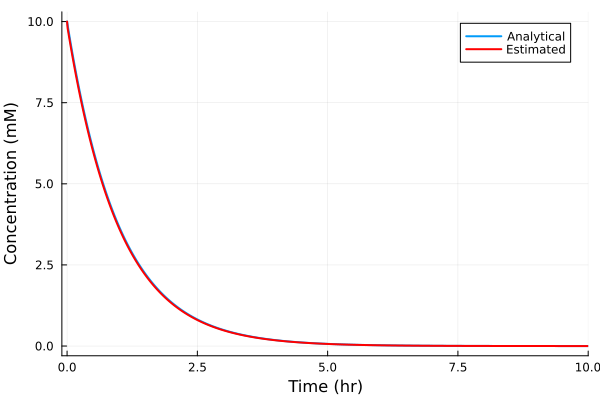

In [16]:
plot(analytical_solution_array[:,1],analytical_solution_array[:,2], xlim=(-0.1,10.0), label="Analytical", lw=2)
plot!(estimated_solution_array[:,1], estimated_solution_array[:,2], c=:red, label="Estimated", lw=2)
xlabel!("Time (hr)", fontsize=18)
ylabel!("Concentration (mM)", fontsize=18)